# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This business case focuses on an e-commerce website's A/B data. The key decision is to choose whether the new or old landing page will lead to more conversions. The decision will also incorporate other metrics to see how they are influenced by page conversions.

First probability is used to understand the dataset and to give hunches about what the A/B test results will be. The next section uses hypothesis testing to analyze the results of the A/B test. Lastly logistic regression is used to see a more precise and different perspective on the relationships between the landing pages. Regression modeling is also used to incorporate other metrics into the A/B test.


<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows and unique users in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
unique_users = len(df.user_id.unique())

In [5]:
duplicated_users = df.shape[0] - len(df.user_id.unique())

The proportion of users converted.

In [6]:
pi_users_converted = df.converted.sum() / df.shape[0]
pi_users_converted

0.11965919355605512

Parts of the A/B dataset has been corrupted. This can be seen by the number of times the `new_page` and `treatment` don't match. It turns out 3893 times the two columns don't match. These rows are corruptes and will later be deleted.

In [7]:
df.sample(10)

,user_id,timestamp,group,landing_page,converted
62710,876721,2017-01-24 10:35:30.164997,treatment,new_page,0
158555,661916,2017-01-22 16:57:19.783971,treatment,new_page,0
271284,687136,2017-01-12 20:10:27.993941,control,old_page,0
31372,720093,2017-01-17 08:08:12.397367,control,old_page,0
166774,720803,2017-01-08 10:32:20.896582,control,old_page,1
214784,723767,2017-01-02 18:45:18.579443,treatment,new_page,0
199170,753295,2017-01-15 21:03:19.981722,control,old_page,1
112811,848141,2017-01-19 20:55:03.391356,treatment,new_page,0
54995,925989,2017-01-04 13:03:38.712461,treatment,new_page,0
22340,671636,2017-01-05 23:52:09.728420,treatment,new_page,0


In [8]:
create_query = lambda x, y: "group == '{}' and landing_page == '{}'".format(x, y)
c, t, o, n = "control", "treatment", "old_page", "new_page"


control_old_cnt = df.query(create_query(c, o)).count()[0]
control_new_cnt = df.query(create_query(c, n)).count()[0]
treatment_old_cnt = df.query(create_query(t, o)).count()[0]
treatment_new_cnt = df.query(create_query(t, n)).count()[0]

results = [control_old_cnt, control_new_cnt,
           treatment_old_cnt, treatment_new_cnt]

In [9]:
assert sum(results) == df.shape[0]

In [10]:
no_match = results[1] + results[2]
no_match

3893

None of the rows have missing values, so that won't need to be changed.

In [11]:
# No
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The incorrectly matched rows are removed below.

In [12]:
df2 = pd.concat([df.query(create_query(c, o)), df.query(create_query(t, n))])

In [13]:
# Double Check all of the correct rows were removed - this should be 0
assert 0 == df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

There is one duplicate Id in the dataset, and it needs to be removed...

In [14]:
duplicate_id = df2[df2.user_id.duplicated()].user_id.reset_index(drop=True)[0]

In [15]:
duplicate_id

773192

In [16]:
delete_index = df2[df2.user_id == duplicate_id].index[1]
delete_index

2893

In [17]:
df2 = df2[df2.index != delete_index]

The non unique user has been removed.

In [18]:
assert df2.user_id.unique().size == df2.shape[0]

Now below we will ask several questions grounded in probability to get a hunch of what are A/B test results may be.

What is the probability of an individual converting regardless of the page they receive?

$P(converted == 1)$

In [19]:
df2[df2.converted == 1].count()[0] / df2.shape[0]

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

$$P(converted == 1|group == control)$$


$$ = \frac{P(group == control \cap converted == 1)}{P(group == control)}$$

In [20]:
control_cnt = df2.query("group == 'control'").count()[0]

control_and_converted_cnt = df2.query("group == 'control' and converted == 1").count()[0]
converted_given_control_prob = control_and_converted_cnt / control_cnt

In [21]:
converted_given_control_prob

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

$$P(converted == 1|group == treatment)$$


$$ = \frac{P(group == treatment \cap converted == 1)}{P(group == treatment)}$$

In [22]:
treatment_cnt = df2.query("group == 'treatment'").count()[0]

treatment_and_converted_cnt = df2.query("group == 'treatment' and converted == 1").count()[0]
converted_given_treatment_prob = treatment_and_converted_cnt / treatment_cnt
converted_given_treatment_prob

0.11880806551510564

What is the probability that an individual received the new page?

In [23]:
new_page_prob = df2.query("landing_page == 'new_page'").count()[0] / df2.shape[0]
new_page_prob

0.5000619442226688

Is there sufficient evidence to conclude that the new treatment page leads to more conversions.

The control group had a slightly higher probability of conversion, which shows that there probably won't be statistically significant evidence to reject the old page in favor of the new page.

However, this result is tentative. We need to perform hypothesis testing to see if we can find statistically significant evidence that our old page may be rejected in favor of our new page.

In [24]:
obs_diff = converted_given_treatment_prob - converted_given_control_prob
obs_diff

-0.0015782389853555567

<a id='ab_test'></a>
### Part II - A/B Test 

They want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, so my null and alternative hypotheses are in terms of **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages:

$$ H0: p_{new} - p_{old} <= 0% $$
$$ H1: p_{new} - p_{old} > 0% $$

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. I will also sssume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [25]:
# Under the null hypothesis, both p_new and p_old have the 
# success rate of the entire dataset
conversion_rate = df2.converted.sum() / df2.shape[0]
conversion_rate

0.11959708724499628

In [26]:
df2.sample(5)

,user_id,timestamp,group,landing_page,converted
180046,745388,2017-01-22 03:57:22.501522,control,old_page,0
272063,700233,2017-01-16 19:11:28.947587,control,old_page,0
168539,919808,2017-01-17 19:10:07.660602,treatment,new_page,0
220904,930294,2017-01-09 16:55:06.035762,control,old_page,0
173802,718313,2017-01-12 10:49:52.912587,control,old_page,0


The **conversion rate** for $p_{new}$ and $p_{old}$ under the null:

In [27]:
print("total_conversion_rate = p_old == p_new == {}".format(conversion_rate))

total_conversion_rate = p_old == p_new == 0.11959708724499628


$n_{new}$, the number of individuals in the treatment group:

In [28]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

$n_{old}$, the number of individuals in the control group:

In [29]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

In [30]:
assert (n_old + n_new) == df2.shape[0]

I will simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
p_new = converted_given_treatment_prob
new_page_converted = np.random.binomial(n=1, p=p_new, size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

I will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
p_old = converted_given_control_prob
old_page_converted = np.random.binomial(n=1, p=p_old, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

I will find $p_{new}$ - $p_{old}$ for my simulated values from above

In [33]:
p_new, p_old = new_page_converted.mean(), old_page_converted.mean()
exp_diff = p_new - p_old
exp_diff

-0.0012546714790657443

I will create 10,000 $p_{new}$ - $p_{old}$ values from all 10,000 values in a NumPy array called **p_diffs**. Note that there are built ins that perform this test for me, but for the purposes of this analysis and for reference later I will perform the test myself and compare the results to the built in for intuition purposes.

In [34]:
SIMULATION_SIZE = 10000
p_new_simulations = np.random.binomial(n=n_new, p=p_new, size=SIMULATION_SIZE) / n_new
p_old_simulations = np.random.binomial(n=n_old, p=p_old, size=SIMULATION_SIZE) / n_old
p_diffs = p_new_simulations - p_old_simulations

In [35]:
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00119278, -0.00208738,  0.00056213, ..., -0.00065599,
       -0.00252094,  0.00054166])

I will plot a histogram of the **p_diffs** and see if it looks like what I expecte.

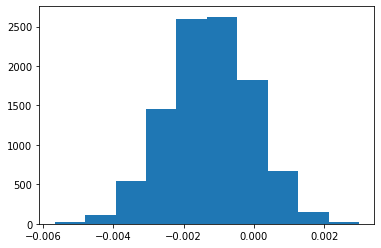

In [36]:
plt.hist(p_diffs);

the proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**:

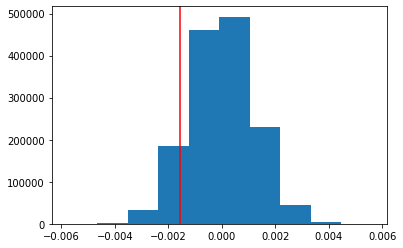

In [37]:
null_vals = np.random.normal(0, p_diffs.std(), df2.size)

plt.hist(null_vals)
plt.axvline(obs_diff, color="red");

In [38]:
(null_vals > obs_diff).mean()

0.905884701153539

Under the null hypothesis, 91% of the values in p_diffs are greater than the observed difference. In other words, there is a 91% chance that if the null hypothesis is rejected it would be a type I error. 

Below I go over:

What was computed above?

What is this value called in scientific studies?

What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p value is computed. The p value is the probability that the observed difference came from the null hypothesis. The null hypothesis in this case is $H_0: p_{new} - p_{old} <= 0$. The null hypothesis is computed by taking the standard deviation of the simultated differences and centering it around a normal distribution with mean 0. The closeness to 0 up to a particular point signifies that the null hypothesis can't be rejected. The p value below a particular level, say 0.05, means that there is only a 5% chance that this value came from the null hypothesis but the null hypothesis has been rejected anyway. That is the type I error rate. So the p value allows the tester to allow for a particular level of type I error rate when rejecting the null hypothesis.

Additionally note here that if we turned the hypothesis around $H_0: p_{new} - p_{old} >= 0$, the p value would be about 9.1%. It would still fail to reject the null hypothesis if a 5% type I error rate is acceptable. Note also that if the hypothesis was changed to $H_0: p_{new} - p_{old} == 0$ it would still fail to reject. Those additional hypothesis' are shown below.

If the hypothesis had been flipped to

$$H_0: p_{new} - p_{old} >= 0$$
$$H_1: p_{new} - p_{old} < 0$$

The null hyothesis would be rejected if $\alpha = 0.1$ but would fail to reject the null for $\alpha = 0.05$

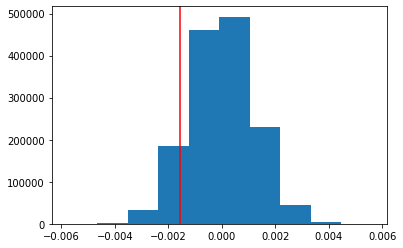

In [39]:
plt.hist(null_vals)
plt.axvline(obs_diff, color="red");

In [40]:
(null_vals < obs_diff).mean()

0.09411529884646092

If the hypothesis had been two sided:

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$

In [41]:
null_mean = null_vals.mean()
low_p = (null_vals < obs_diff).mean()
high_p = (null_vals > obs_diff + (null_mean - obs_diff)).mean()
p_val = low_p + high_p

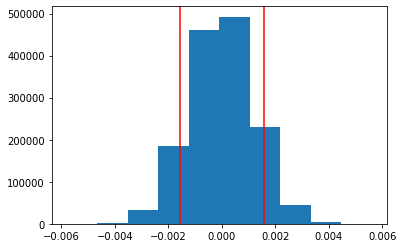

In [42]:
plt.hist(null_vals)

low=obs_diff
high=null_mean + (null_mean - obs_diff)
plt.axvline(low, color="red");
plt.axvline(high, color="red");

In [43]:
low_p, high_p

(0.09411529884646092, 0.4998905652066184)

In [44]:
p_val

0.5940058640530793

The low_p value below is the probability that the observed difference in the sample came at the left side of the null distribution. It is the p value assocaited with the null values associated with being more extreme then the observed sample difference. 

The high p value is associated with the observed difference occurring on the right side, and the probability that it came from that side of the distribution. 

The p value can also be viewed as highlighting the area under the curve to the left of the left vertical line and to the right of the right verical line. 

The two values are added and tested against a type I error rate to see if it has statisitical significance. In this case the p vaue is about 0.6, which states that about 60% of the time, the observed difference would have come from the null distribution. Because the type I error allowed ($\alpha$) is 0.05 the null hypothesis has failed to be rejected here. 

Using the built in:

In [45]:
# Note: There is a bug where statsmodels breaks on first build unless
# the API is imported before the statsmodel directly. 
# The reason why this occurs is unclear. This seems to solve the issue.
import statsmodels.api as sm

In [46]:
import statsmodels as sm
convert_old = df2.query("landing_page == 'old_page'").converted.sum()
convert_new = df2.query("landing_page == 'new_page'").converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

`stats.proportions_ztest` computes my test statistic and p-value:

$$H_0 : p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

In [47]:
z_test = sm.stats.proportion.proportions_ztest
results = z_test(count=convert_new, nobs=n_new, value=convert_old / n_old, alternative="larger")
results

(-1.859354929150913, 0.9685115770700896)

Below I answer:

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?

Do they agree with the findings where I didn't use the built in?

The hypothesis here is that the new porportion is larger than the old porportion given conversion rates and sample size. The z statistic states that the observed difference in the data is 1.85 standard deviations to the left of the mean. The p value is the probability that the observed difference fell somewhere within the null hyothesis. In this case, it means that the probability that the null hypothesis fails to be rejected is 0.968. The null hypothesis therefore fails to be rejected. 

In this case, if the alternative hypothesis is flipped to smaller or two sided, it is statisitically significant with a type I error rate of 0.07 for both and 0.05 for the smaller alternative. This means that with a type I error rate selected to be 0.05, their is statistically significant evidence that the old page has a better conversion rate than the new page.

Therefore if the hypothesis were 
$$H_0: p_{new} - p_{old} >= 0$$
$$H_0: p_{new} - p_{old} < 0$$
the null hypothesis can be rejected for the alternative given a type I error rate of 0.05.


In [48]:
results = z_test(count=convert_new, nobs=n_new, value=convert_old / n_old, alternative="smaller")
results

(-1.859354929150913, 0.03148842292991042)

For a two sided t test, a p-value of 0.06 is computed, signifying statistical significance if $\alpha = 0.1$

In [49]:
results = z_test(count=convert_new, nobs=n_new, value=convert_old / n_old, alternative="two-sided")
results

(-1.859354929150913, 0.06297684585982084)

The p values are ordinally correct compared with the previous computation. The larger test has a larger p value than the two sided test, which is larger than the smaller test. However the values are very different:

```
Both: smaller_test < two_sided < larger_test

Manual: $0.03 < 0.06 < 0.97$

Built In: $0.09 < 0.59 < 0.91$

```

The reason why the numbers come out differently isn't certain by the writer at this time.

<a id='regression'></a>
### Part III - A regression approach

Regression can also be used to achieve the same results as the A/B test:
<br><br> 

The model chosen will be a logistic regression model, because the target metric is conversion which is categorical. The prediction labels will be 0 and 1 for no conversion and conversion.

The goal is to use **statsmodels** to fit the regression model I specified above to see if there is a significant difference in conversion based on which page a customer receives.

However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  I will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [50]:
df2["intercept"] = 1
df2[["has_newpage", "has_old_page"]] = pd.get_dummies(df2["landing_page"])
df2.drop(columns="has_old_page", inplace=True)
df2.sample(8)

,user_id,timestamp,group,landing_page,converted,intercept,has_newpage
202558,709616,2017-01-15 05:32:05.439627,treatment,new_page,1,1,1
269674,833156,2017-01-17 17:28:23.773471,treatment,new_page,0,1,1
204266,855912,2017-01-20 22:55:39.185455,treatment,new_page,0,1,1
24131,696567,2017-01-13 16:07:31.704111,treatment,new_page,1,1,1
233856,849659,2017-01-15 00:10:59.437062,treatment,new_page,1,1,1
13412,923227,2017-01-09 11:53:25.009293,control,old_page,0,1,0
90101,777780,2017-01-04 22:54:52.244799,control,old_page,0,1,0
147434,643564,2017-01-18 13:56:25.431732,treatment,new_page,1,1,1


The timestamp data will also be modeled. The military hour and the day as integer values will be incorporated into the model. That will give predictive power given time of day and the date chosen. The time will be between 0 and 23 and the day will be between 2 and 24 (the test ran for 22 days in January 2017).

They will be extracted from the timestamp and given their own columns `hour` and `day`.

In [51]:
from datetime import datetime
format_str = '%Y-%m-%d %H:%M:%S.%f'
df2["day"] = df2.timestamp.apply(lambda x: datetime.strptime(x, format_str).day).astype(int)
df2["hour"] = df2.timestamp.apply(lambda x: datetime.strptime(x, format_str).hour).astype(int)

In [52]:
df2.sample(3)

,user_id,timestamp,group,landing_page,converted,intercept,has_newpage,day,hour
170193,636008,2017-01-07 02:23:54.828558,control,old_page,0,1,0,7,2
225846,830761,2017-01-08 01:24:16.989670,control,old_page,0,1,0,8,1
85075,740119,2017-01-11 04:12:01.861539,control,old_page,0,1,0,11,4


In [53]:
assert (2, 24) == (df2.day.unique().min(), df2.day.unique().max())
assert (0, 23) == (df2.hour.unique().min(), df2.hour.unique().max())

 **statsmodels** will instantiate my regression model on the two columns created above.

In [54]:
import statsmodels.api as sm

In [55]:
results_new_page = sm.Logit(df2['converted'], df2[['intercept', 'has_newpage']]).fit()
results_day = sm.Logit(df2['converted'], df2[['intercept', 'day']]).fit()
results_hour = sm.Logit(df2['converted'], df2[['intercept', 'hour']]).fit()
results_day_hour = sm.Logit(df2['converted'], df2[['intercept', 'hour', "day"]]).fit()
results_new_page_day = sm.Logit(df2['converted'], df2[['intercept', 'has_newpage', "day"]]).fit()
results_new_page_hour = sm.Logit(df2['converted'], df2[['intercept', 'has_newpage', "hour"]]).fit()
results_new_page_day_hour = sm.Logit(df2['converted'], df2[['intercept', 'has_newpage', "hour", "day"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366102
         Iterations 6


The summary of the model is below

Below the following models are tested:

- new_page, intercept

- day, intercept

- hour, intercept

- day, hour, intercept

- new_page, day, intercept

- new_page, hour, intercept

- new_page, day, hour, intercept

For the two sided test shown in the summary, only `hour` provides statistical significance. However when using the z score for one sided tests, the other two metrics are statisitically significant for $\alpha = 0.1$ but not for $\alpha = 0.05$. 

The associated change for each metric is a 1% increase in conversions for each military hour and a 1% increase for each day in that passes in the test. A 1% decrease is associated with using the new landing page rather than the older one. 

1% as an increase or decrease provides practical significance because over a 20 day period a 1% change in conversions would lead to roughly a 3000 unit increase or decrease in conversions according to the test data.

The best model depends on what value is chosen for $\alpha$. If $\alpha = 0.1$ the model `new_page, hour, day, intercept` could be the best model. It provides statistical significance on all metrics for either one sided tests or two sided tests, and could therefore be used to make the richest predictions. If $\alpha = 0.05$ the only useful model would prove to be `hour, intercept` because of statistical significance. However that isn't the purpose of this AB test, and more data should be collected if that $\alpha$ rate is chosen

In [56]:
import math

In [57]:
results_new_page.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:23:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
has_newpage    -0.0150      0.011     -1.311      0.190      -0.037       0.007
===============================================================================
"""

In [58]:
has_newpage = -0.0150
mult_change_newpage = math.exp(has_newpage)
1 / mult_change_newpage

1.015113064615719

In [59]:
import scipy

In [60]:
p_value_one_sided = scipy.special.ndtr(-1.311)
p_value_one_sided

0.09492888180526626

This model shows that the new page results in it being slightly less likely for a conversion to occur. If a new page occurs is a little bit above 1% decrease in liklihood that it will lead to a conversion. 

It isn't statistically significant for the two sided test because the P value is 0.19. However it is statistically significant for the one sided test if $\alpha = 0.1$

In [61]:
results_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               1.000e-05
Time:                        09:23:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1446
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0134      0.013   -153.778      0.000      -2.039      -1.988
day            0.0013      0.001      1.459      0.145      -0.000       0.003
==============================================================================
"""

In [62]:
day = 0.0013
mult_change_day = math.exp(day)
mult_change_day

1.0013008453662857

In [63]:
p_value_one_sided = scipy.special.ndtr(-1.459)
p_value_one_sided

0.07228255384515922

This model shows that if the day of the week is later in the trial, there is a 1% increase in liklihood for a conversion. 

It isn't statistically significant with a p value of 0.145 for two sided tests. However it is statistically significant for $\alpha=0.1$ on a one sided test.

In [64]:
results_hour.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               3.350e-05
Time:                        09:23:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.007588
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0217      0.011   -181.312      0.000      -2.044      -2.000
hour           0.0022      0.001      2.670      0.008       0.001       0.004
==============================================================================
"""

In [65]:
hour = 0.0022
mult_change_hour = math.exp(hour)
mult_change_hour

1.0022024217756431

The model above shows that an increase in 1% of a conversion happens as the hour of the day gets higher.

It is statistically significant with a p value below 1% for both a one sided and two sided test. This relationship should be investigated further as it leads to practically important results.

In [66]:
results_day_hour.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               4.612e-05
Time:                        09:23:43   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.007399
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0421      0.017   -122.243      0.000      -2.075      -2.009
hour           0.0023      0.001      2.772      0.006       0.001       0.004
day            0.0015      0.001      1.638      0.101      -0.000       0.003
==============================================================================
"""

In [67]:
p_value_one_sided_1 = scipy.special.ndtr(-2.772)
p_value_one_sided_2 = scipy.special.ndtr(-1.638)
p_value_one_sided_1, p_value_one_sided_2

(0.002785651827813589, 0.05071084689132204)

This model contains day and hours.  It provides one sided statistical significance for days and one sided for hours almost for $\alpha = 0.05$. 

In [68]:
results_new_page_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               1.805e-05
Time:                        09:23:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1466
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0059      0.014   -140.442      0.000      -2.034      -1.978
has_newpage    -0.0150      0.011     -1.308      0.191      -0.037       0.007
day             0.0013      0.001      1.456      0.145      -0.000       0.003
===============================================================================
"""

In [69]:
p_value_one_sided_1 = scipy.special.ndtr(-1.308)
p_value_one_sided_2 = scipy.special.ndtr(-1.456)
p_value_one_sided_1, p_value_one_sided_2

(0.09543665464286744, 0.07269630980500974)

Both provide statistical significance for $\alpha = 0.1$ but isn't useful for $\alpha = 0.05$

In [70]:
results_new_page_hour.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               4.156e-05
Time:                        09:23:45   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01202
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0142      0.013   -160.898      0.000      -2.039      -1.990
has_newpage    -0.0150      0.011     -1.309      0.190      -0.037       0.007
hour            0.0022      0.001      2.669      0.008       0.001       0.004
===============================================================================
"""

In [71]:
p_value_one_sided_1 = scipy.special.ndtr(-1.309)
p_value_one_sided_2 = scipy.special.ndtr(-2.669)
p_value_one_sided_1, p_value_one_sided_2

(0.09526717536744495, 0.0038038725126533224)

Hour has statistical significance, but has_newpage has it for $\alpha = 0.1$. 

In [72]:
results_new_page_day_hour.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               5.414e-05
Time:                        09:23:46   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.009227
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0346      0.018   -115.238      0.000      -2.069      -2.000
has_newpage    -0.0149      0.011     -1.306      0.192      -0.037       0.007
hour            0.0023      0.001      2.771      0.006       0.001       0.004
day             0.0015      0.001      1.636      0.102      -0.000       0.003
===============================================================================
"""

In [73]:
p_value_one_sided_1 = scipy.special.ndtr(-1.306)
p_value_one_sided_2 = scipy.special.ndtr(-2.771)
p_value_one_sided_3 = scipy.special.ndtr(-1.636)
p_value_one_sided_1, p_value_one_sided_2, p_value_one_sided_3

(0.0957762787858698, 0.0027942213407647766, 0.05091979369804819)

Hour has statistical significance and day almost does for $\alpha = 0.05$. For $alpha = 0.1$ this is the most useful model so far.

Below I answer a few questions related to some vocabulary to clarify my understanding:

What is the p-value associated with **ab_page**?

Why does it differ from the value I found above?<br><br>

I also think it is good to think about what are the null and alternative hypotheses associated with the regression model, and how do they compare to the null and alternative hypotheses above?

Results for the `new_page, intercept` model are below for convienence.

In [74]:
results_new_page.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:23:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
has_newpage    -0.0150      0.011     -1.311      0.190      -0.037       0.007
===============================================================================
"""

In [75]:
has_newpage = -0.0150
mult_change_newpage = math.exp(has_newpage)
1 / mult_change_newpage

1.015113064615719

Below is the left sided p value of the new_page, which does hold statistical significance if $\alpha = 0.1$

In [76]:
import scipy
p_val = scipy.special.ndtr(-1.311)
p_val

0.09492888180526626

The results are that a 1% decrease in the chance for conversion is associated with the new landing page being used. They don't hold statistical significance significance with a pvalue of 0.19.

Both the conditional probability calculations, ztests, and the logistice regression agree that the new page results in a slightly less chance for a conversion. The ztests used were smaller, larger, and two sided. Only two sided is used in logistic regression resulting in a higher P Value of 0.19. 

The p value for the two sided test was not statistically significant for the logistic regression or the two sided z test done in the hypothesis testing section. However the p value allows for statisically significance if $\alpha = 0.1$ for the smaller side z-test. The logistic regression has a similar value for a left sided z test as show below. Therefore both the logistic regression and the smaller sided z test both have statisically significant results for $\alpha=0.1$. 


These results would lead to the conclusion that using the old landing page is associated with an increase of 1% in conversions. Over a 20 day period 290584 users were tested in using both landing pages. If the old page delivers a 1% increase, it would lead to 2905 more conversions over a 20 day period. This seems to be practically important as well as statistically significant for $\alpha = 0.1$


We can also add other variables to our A/B test by making our regression model more complex:

Now, I am considering other things that might influence whether or not an individual converts. I will discuss the tradeoffs of adding in more features to my model:

Before examing the above question,  lets examine a model using more variables.

Notice the model of day, hour and new_page below. Assume $\alpha = 0.1$.

In [77]:
results_new_page_day_hour.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               5.414e-05
Time:                        09:23:46   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.009227
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0346      0.018   -115.238      0.000      -2.069      -2.000
has_newpage    -0.0149      0.011     -1.306      0.192      -0.037       0.007
hour            0.0023      0.001      2.771      0.006       0.001       0.004
day             0.0015      0.001      1.636      0.102      -0.000       0.003
===============================================================================
"""

Below is the multiplicative change, with hour and day leading to an increase and new_page leading to a decrease

In [78]:
hour_coef, day_coef, new_page_coef = 0.0023,0.0015, -0.0149
hour_z, day_z, new_page_z = 2.771, 1.636, -1.306
hour_chg, hour_p = math.exp(hour_coef), scipy.special.ndtr(-hour_z)
day_chg, day_p = math.exp(day_coef), scipy.special.ndtr(-day_z)
new_page_chg, new_page_p = 1/math.exp(new_page_coef), scipy.special.ndtr(new_page_z)

In [79]:
print("Hour Change: {:.4f}% Hour P: {:.4f}".format(hour_chg, hour_p))
print("Day Change: {:.4f}% Hour P: {:.4f}".format(day_chg, day_p))
print("New Page Change: {:.4f}% Hour P: {:.4f}".format(-new_page_chg, new_page_p))

Hour Change: 1.0023% Hour P: 0.0028
Day Change: 1.0015% Hour P: 0.0509
New Page Change: -1.0150% Hour P: 0.0958


This shows that if we reformulate our hypothesis and allow for a type I error rate of 0.1, the website could make changes that could lead to 1% increases in conversions for decisions made. Over a 20 day period, a 1% increase if there were around 30,000 customers (as seen in the data) is 3000 more conversions. The hypothesis predict that later in the month, later in the day, and using the old landing page could lead to increases of 1% depending on the decision made. This is practically important.

The reformultion of the hypothesis would be to predict the hour and day in the greater tail (predicting that a later hour and a later day in the month leads to more conversions) and to predict that the old landing page is better than the new landing page (in the left side of the tail). 

Due note though the limitations of this model. It predicts every day that there is an increase of 1% on average, which seems overly optimistic. It also states that in each hour in the day there is an increase of 1%. This might be better represented in looking at time series trends then using this logistic model and finding peak time for conversions.

Also the type I error rate is 10%, which is higher than what is originally wanted of 5%.

Now to answer the original question posed. Notice how as we added in more variables into the models, the business decisions that could be made increased. The plan of what to do becomes richer and more detailed. But also more assumptions are made and details become muddy. In the case of this analysis, the tradeoff was richness of analysis to complexity. The model therefore becomes harder to interpret, which makes mistakes more likely to be made when adding in more variables, but it also gives more insight. Additionally it isn't known how the variables relate to each other. Analyzing for multicollinearity and other metrics that signify possibly misleading results can be used, but once again that just adds to the complexity of the analysis. Whenever complexity is added errors are more likely to be made. A VIF matrix below confirms that multicolinnearity is unlikely for the `day hour new_page` model.

In the case of this analysis, it is a good place to start. But from here it would probably be a good idea to investigate the hours and days varaibles using a time series approach and going back to the model of just `new_page intercept`. That would lead to a simple model to investigate the ab test and more accurate time series models to see the trends in days and hours.

Another variable not considered is time. If a type I error rate of 0.1 is unacceptable, that would signify to collect another sample of data and see if statistical significance is achieved at an acceptable type I error rate. 

In [80]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
y, X = dmatrices(' converted ~ has_newpage + day + hour', df2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [81]:
vif

,VIF Factor,features
0,9.476725,Intercept
1,1.000004,has_newpage
2,1.004358,day
3,1.004354,hour


Now along with testing if the conversion rate changes for different pages, we can add an effect based on which country a user lives in. First I need to perform a join operation. 

Does it appear that country had an impact on conversion? I need to create dummy variables for these country columns - I will need two columns for the three dummy variables.

In [82]:
countries_df = pd.read_csv("countries.csv")
df2 = pd.merge(df2, countries_df, how="left", on="user_id")

In [83]:
assert len(df2.country.unique()) == 3

In [84]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [85]:
columns = ["CA", "UK", "US"]
df2[columns] = pd.get_dummies(df2["country"])

In [86]:
df2.sample(3)

,user_id,timestamp,group,landing_page,converted,intercept,has_newpage,day,hour,country,CA,UK,US
234856,823609,2017-01-20 07:03:55.294320,treatment,new_page,0,1,1,20,7,US,0,0,1
58456,831918,2017-01-12 09:31:00.639898,control,old_page,0,1,0,12,9,US,0,0,1
205700,746992,2017-01-16 07:49:49.230956,treatment,new_page,0,1,1,16,7,US,0,0,1


In [87]:
results_country = sm.Logit(df2['converted'], df2[['intercept', "UK", "US"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [88]:
results_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:23:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [89]:
uk_coef, us_coef, int_coef = 0.0507, 0.0408, 2.0375
uk_chg, us_chg, int_chg = math.exp(uk_coef), math.exp(us_coef), -1/math.exp(int_coef)
uk_chg, us_chg, int_chg

(1.052007243765014, 1.0416437559600236, -0.13035418933417164)

It seems there is a roughly 1.05% increase in conversion rate if the user is from uk or us that isn't present of the user is canadian. Now statistical significance will be tested.

In [90]:
z = scipy.special.ndtr
uk_z, us_z = 1.786, 1.518
uk_p, us_p = z(-uk_z), z(-us_z)
uk_p, us_p

(0.03704962906819025, 0.06450719933248307)

It seems that if a one sided test is used, both US and UK hold statistical significance with $\alpha=0.1$

Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [91]:
results_newpage_country = sm.Logit(df2['converted'], df2[['intercept', 'has_newpage', "UK", "US"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [92]:
results_newpage_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        09:23:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0300      0.027    -76.249      0.000      -2.082      -1.978
has_newpage    -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK              0.0506      0.028      1.784      0.074      -0.005       0.106
US              0.0408      0.027      1.516      0.130      -0.012       0.093
===============================================================================
"""

In [93]:
newpage_coef, uk_coef, us_coef, int_coef = -0.0149, 0.0506, 0.0408, -2.03
newpage_chg, uk_chg, us_chg, int_chg = -1 / math.exp(newpage_coef), math.exp(uk_coef), \
                                            math.exp(us_coef), -1/math.exp(int_coef)
newpage_chg, uk_chg, us_chg, int_chg

(-1.0150115583846535,
 1.0519020483004984,
 1.0416437559600236,
 -7.614086358779972)

It appears that roughly the same 1.05% increase in liklihood of conversion occurs if the user is from the UK or US. This 1% bump doesn't occur if the user is from canada. The 1% decrease in liklihood of a conversion if the user sees the new landing page is also still present. Below statistical significance will be investigated.

In [94]:
z = scipy.special.ndtr
newpage_p, uk_p, us_p = z(-1.307), z(-1.784), z(-1.516)
newpage_p, uk_p, us_p

(0.09560635574220494, 0.037211832579700385, 0.0647596762031546)

It seems they hold statistical significance for their respective one sided test $\alpha= 0.1$

Lastly a VIF matrix will be generated to test for multicollinearity that might lead to misleading results.

In [95]:
y, X = dmatrices('converted ~ has_newpage + UK + US', df2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [96]:
vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,has_newpage
2,4.502236,UK
3,4.502223,US


There doesn't seem to be multicollinearity issues given this VIF analysis. If there were VIF values above 20 for any metric (other than the intercept) than it would suggest correlation between independent variables.